# Imports and Data Loading

In [1]:
import re

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb
from lightgbm import LGBMRegressor
from scipy.sparse import csr_matrix, hstack
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import (mean_absolute_error, r2_score,
                             root_mean_squared_error)
from sklearn.model_selection import (KFold, RandomizedSearchCV, cross_validate,
                                     train_test_split)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.svm import SVR
from xgboost import XGBRegressor

c:\Users\khali\OneDrive\Bureau\DSTI\S25 S1\Machine Learning with Python Labs\Project\Project 1\S25---ML-Project-Book-Rating-Prediction\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_Folder = "./Data/"
MODELS_FOLDER = "./Models/"

In [3]:
df = pd.read_csv(f"{DATA_Folder}books.csv", on_bad_lines='skip')

# Exploratory Data Analysis (EDA)

## Data informations

In [4]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7     num_pages         11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB


In [6]:
df = df.rename(columns={"  num_pages": "num_pages"})

In [7]:
df.shape

(11123, 12)

In [8]:
df.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000
mean,21310.856963,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099
std,13094.727252,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000
75%,32104.500000,4.140000,9.780872e+12,416.000000,5.000500e+03,238.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


In [9]:
df.isnull().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

## Number of books with 0 rating

In [10]:
books_zero_rating = df[df['average_rating'] == 0]
num_pages_zero_count = len(books_zero_rating)

print(f"Found {num_pages_zero_count} book(s) with 0 average_rating:")
books_zero_rating[['bookID', 'title', 'average_rating','ratings_count']].head()

Found 25 book(s) with 0 average_rating:


,bookID,title,average_rating,ratings_count
265,799,Out to Eat London 2002 (Lonely Planet Out to Eat),0.0,0
375,1302,Juiced Official Strategy Guide,0.0,0
987,3351,Open City 6: The Only Woman He Ever Left,0.0,0
2532,9337,How To Meditate: An Anthology Of Talks On Medi...,0.0,0
2533,9338,Insights: Talks On The Nature Of Existence,0.0,0


## Duplicated Titles

In [11]:
#We see if there are any duplicated titles in the dataset
duplicates_df = df[df.duplicated(subset=['title', 'authors', 'average_rating'], keep=False)]

redundancy_df = (
    duplicates_df
    .groupby(['title', 'authors', 'average_rating'])
    .agg(
        repetition=('bookID', 'size'),
        **{
            f'{col}_diff': (
                col,
                lambda s: s.unique().tolist() if s.nunique() > 1 else np.nan
            )
            for col in df.columns.difference(['title', 'authors', 'average_rating'])
        }
    )
    .reset_index()
)
redundancy_df = redundancy_df.dropna(axis=1, how='all')

In [12]:
total_duplicated_rows = redundancy_df['repetition'].sum()
print(f"Total number of duplicated book entries: {total_duplicated_rows}")

Total number of duplicated book entries: 574


In [13]:
redundancy_df.head()

,title,authors,average_rating,repetition,bookID_diff,isbn_diff,isbn13_diff,language_code_diff,num_pages_diff,publication_date_diff,publisher_diff,ratings_count_diff,text_reviews_count_diff
0,'Salem's Lot,Stephen King,4.02,5,"[5415, 5419, 5420, 19137, 36303]","[0965772411, 0451092317, 0340770538, 045109827...","[9780965772419, 9780451092311, 9780340770535, ...","[eng, en-US]","[405, 427, 586, 817]","[10/17/1975, 11/13/1979, 10/6/2010, 8/1/1976]","[Doubleday, Signet, Hodder & Stoughton Ltd]","[1039, 178, 25, 18, 186]","[130, 35, 6, 3, 22]"
1,'Salem's Lot,Stephen King/Ron McLarty,4.02,2,"[5414, 19135]","[0743536967, 0743536959]","[9780743536967, 9780743536950]","[eng, en-US]","[17, 0]",NaN,NaN,"[227, 56]","[54, 5]"
2,A Hard Day's Write: The Stories Behind Every B...,Steve Turner,4.18,2,"[35552, 35666]","[0060844094, 0062736981]","[9780060844097, 9780062736987]",NaN,NaN,"[10/18/2005, 11/1/1999]","[It Books, HarperResource]","[156, 2072]","[10, 100]"
3,A History of God: The 4 000-Year Quest of Juda...,Karen Armstrong,3.87,2,"[3873, 27303]","[0517223120, 0345384563]","[9780517223123, 9780345384560]",NaN,"[460, 496]","[3/2/2004, 8/9/1994]","[Gramercy Books, Ballantine Books]","[38915, 1343]","[1087, 144]"
4,A Painted House,John Grisham,3.70,2,"[5360, 45149]","[0385337930, 0099416158]","[9780385337939, 9780099416159]",NaN,"[384, 466]","[2/3/2004, 9/29/2002]","[Bantam, Arrow Books]","[67857, 484]","[3375, 48]"


this shows that even though there are many redundencies in book titles, it doesn't mean that they need to be removed, but rather emphasises on the importance of publisher, publication year => the books edition release

## Books with 0 pages

In [14]:
num_pages_zero_count = (df['num_pages'] == 0).sum()
print(f"Number of books with 0 pages: {num_pages_zero_count}")

Number of books with 0 pages: 76


In [15]:
num_pages_zero_books = df[df['num_pages'] == 0]
num_pages_zero_count = len(num_pages_zero_books)

print(f"Found {num_pages_zero_count} book(s) with 0 pages:")
print(num_pages_zero_books[['bookID', 'title', 'num_pages']])

Found 76 book(s) with 0 pages:
       bookID                                              title  num_pages
306       955  The 5 Love Languages / The 5 Love Languages Jo...          0
853      2835                   The Tragedy of Pudd'nhead Wilson          0
1061     3593  Murder by Moonlight & Other Mysteries (New Adv...          0
1064     3599  The Unfortunate Tobacconist & Other Mysteries ...          0
1230     4249             The Da Vinci Code (Robert Langdon  #2)          0
...       ...                                                ...        ...
10026   40378                  The Chessmen of Mars (Barsoom #5)          0
10188   41273                     Fine Lines (One-Eyed Mack  #6)          0
10620   43343  Stowaway and Milk Run: Two Unabridged Stories ...          0
10922   44748                        The Mask of the Enchantress          0
11077   45472  Treasury of American Tall Tales: Volume 1: Dav...          0

[76 rows x 3 columns]


In [16]:
df = df[df['num_pages'] != 0]

this reflect book editions with 0 pages, might be audiobooks

## Publication dates

In [17]:
original_publication_dates = pd.to_datetime(df['publication_date'], errors='coerce')
invalid_date_count = original_publication_dates.isnull().sum()

print(f"Number of rows with invalid publication dates: {invalid_date_count}")

Number of rows with invalid publication dates: 2


In [18]:
df['parsed_date'] = pd.to_datetime(df['publication_date'], errors='coerce')
invalid_date_rows = df[df['parsed_date'].isnull()]
invalid_date_count = len(invalid_date_rows)
print(f"Found {invalid_date_count} row(s) with invalid publication dates:")
print(invalid_date_rows[['bookID', 'title', 'publication_date']])

Found 2 row(s) with invalid publication dates:
       bookID                                              title  \
8177    31373  In Pursuit of the Proper Sinner (Inspector Lyn...   
11094   45531         Montaillou  village occitan de 1294 à 1324   

      publication_date  
8177        11/31/2000  
11094        6/31/1982  


In [19]:
#these dates where looked up in google
df.loc[df['bookID'] == 31373, 'publication_date'] = '10/31/2000'
df.loc[df['bookID'] == 45531, 'publication_date'] = '04/23/1982'

#checking if everything was corrected
original_publication_dates = pd.to_datetime(df['publication_date'], errors='coerce')
invalid_date_count = original_publication_dates.isnull().sum()

print(f"Number of rows with invalid publication dates: {invalid_date_count}")

Number of rows with invalid publication dates: 0


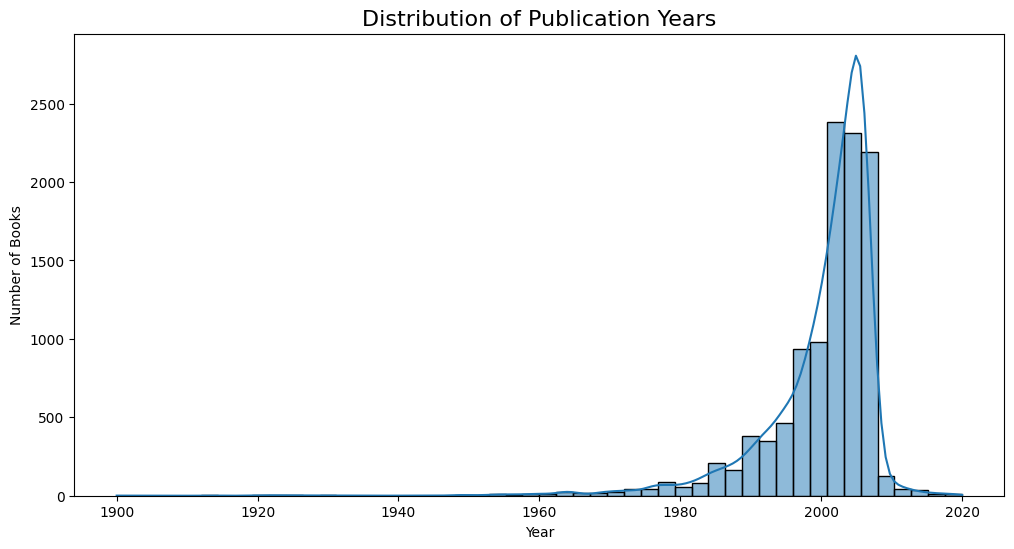

In [20]:
df['publication_year'] = pd.to_datetime(df['publication_date'], errors='coerce').dt.year

plt.figure(figsize=(12, 6))
sns.histplot(df['publication_year'].dropna(), bins=50, kde=True)
plt.title('Distribution of Publication Years', size=16)
plt.xlabel('Year')
plt.ylabel('Number of Books')
plt.show()


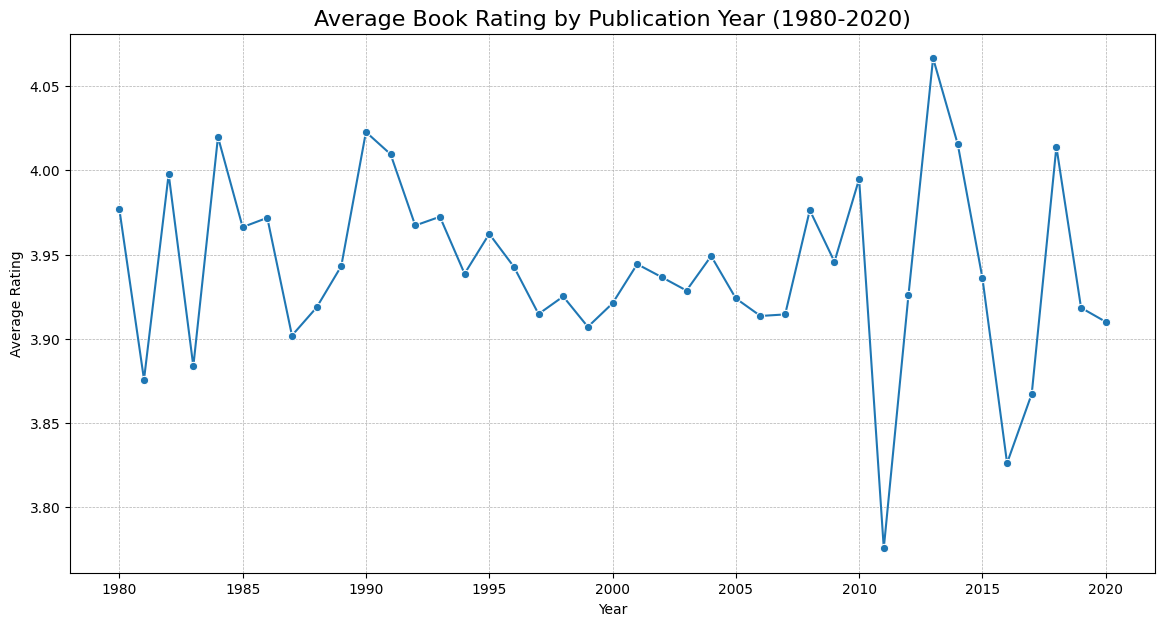

In [21]:
df['publication_year'] = pd.to_datetime(df['publication_date'], errors='coerce').dt.year

yearly_avg_rating = df.groupby('publication_year')['average_rating'].mean().reset_index()
yearly_avg_rating = yearly_avg_rating[(yearly_avg_rating['publication_year'] >= 1980) & (yearly_avg_rating['publication_year'] <= 2020)]

plt.figure(figsize=(14, 7))
sns.lineplot(data=yearly_avg_rating, x='publication_year', y='average_rating', marker='o')
plt.title('Average Book Rating by Publication Year (1980-2020)', size=16)
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

df.drop(columns=['publication_year'], inplace=True, errors='ignore')


Book counts and average ratings for years 2010-2015:
    publication_year  average_rating  book_count
76              2010        3.994865          37
77              2011        3.775417          24
78              2012        3.925714          21
79              2013        4.066667          15
80              2014        4.015556           9
81              2015        3.936000          10


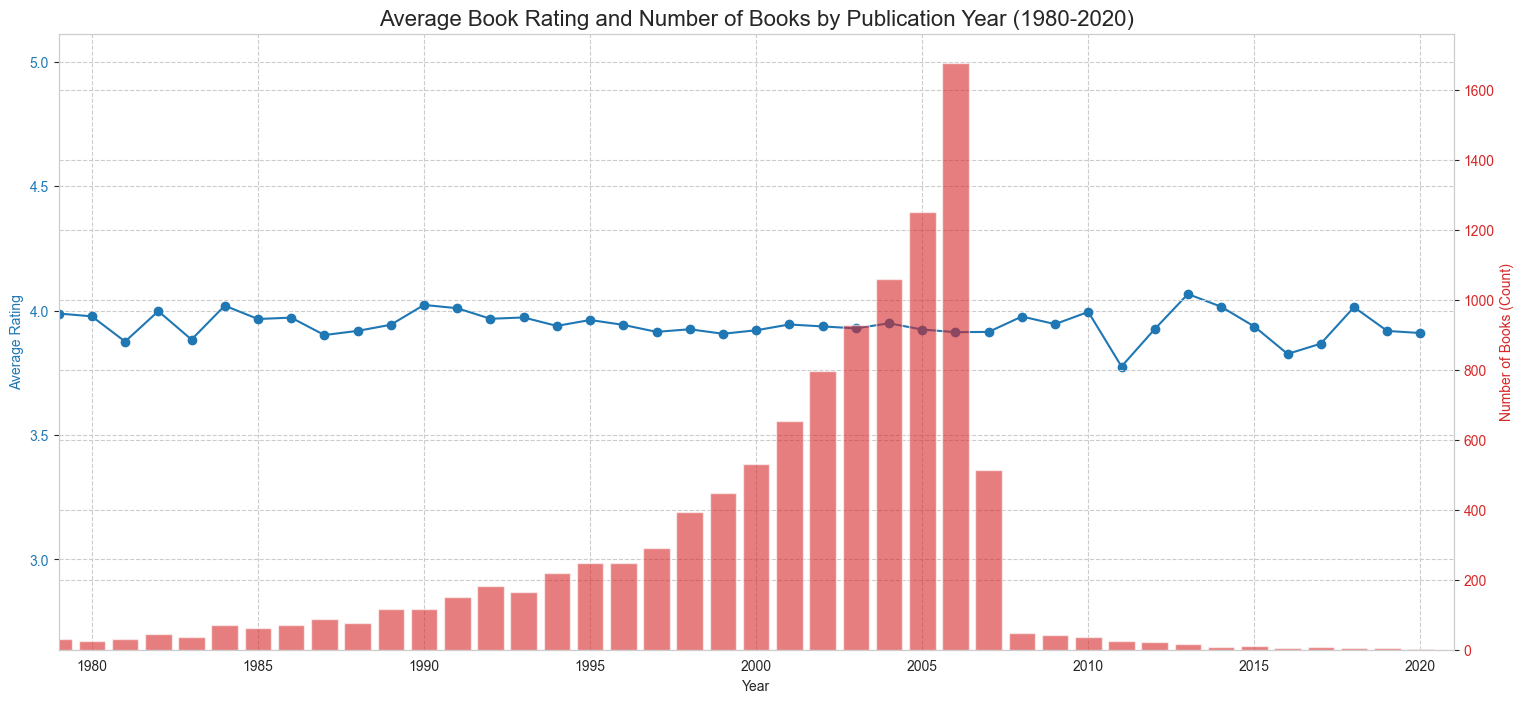

In [22]:
df['publication_year'] = pd.to_datetime(df['publication_date'], errors='coerce').dt.year

yearly_stats = df.groupby('publication_year')['average_rating'].agg(['mean', 'count']).reset_index()
yearly_stats = yearly_stats.rename(columns={'mean': 'average_rating', 'count': 'book_count'})
yearly_stats = yearly_stats.sort_values('publication_year')

print("\nBook counts and average ratings for years 2010-2015:")
print(yearly_stats[(yearly_stats['publication_year'] >= 2010) & (yearly_stats['publication_year'] <= 2015)])

sns.set_style("whitegrid", {'grid.linestyle': '--'})
fig, ax1 = plt.subplots(figsize=(18, 8))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Rating', color=color)
ax1.plot(yearly_stats['publication_year'], yearly_stats['average_rating'], color=color, marker='o', label='Average Rating')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Average Book Rating and Number of Books by Publication Year (1980-2020)', fontsize=16)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Number of Books (Count)', color=color)
ax2.bar(yearly_stats['publication_year'], yearly_stats['book_count'], color=color, alpha=0.6, label='Number of Books')
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_xlim(1979, 2021)
ax1.grid(True)


## Plots

In [23]:
numerical_features = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']

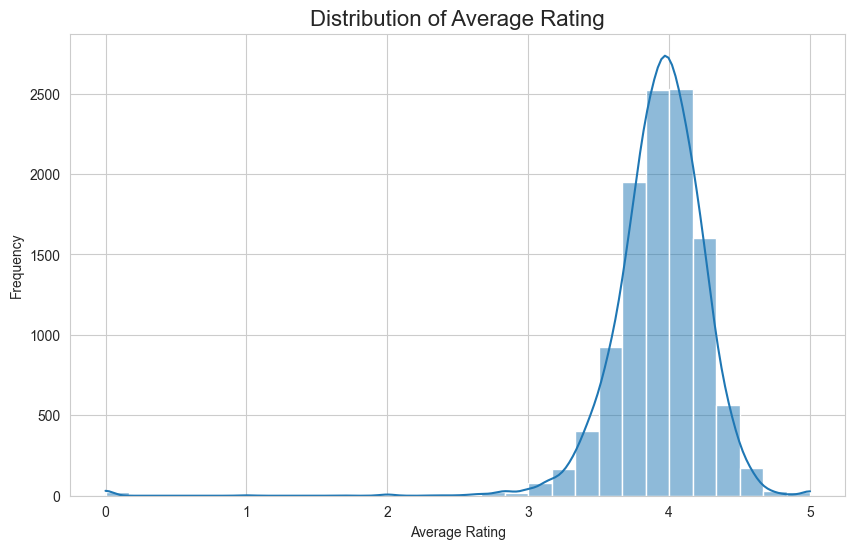

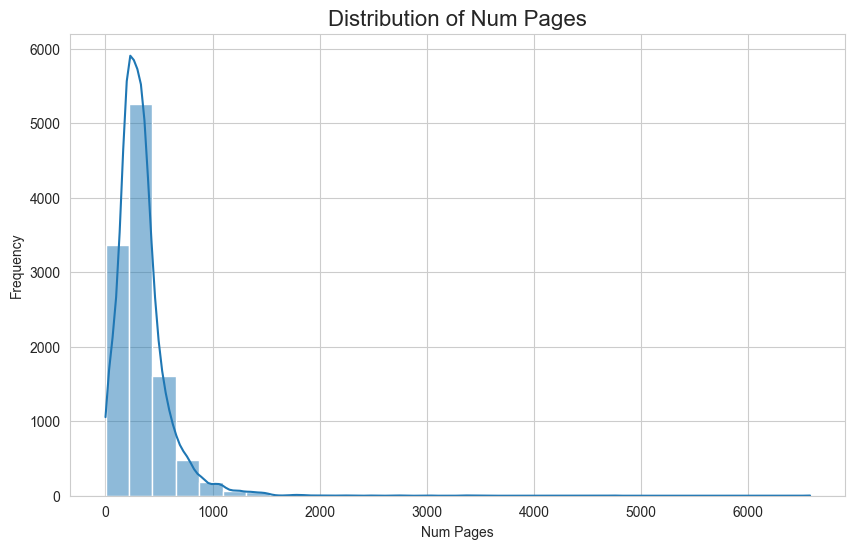

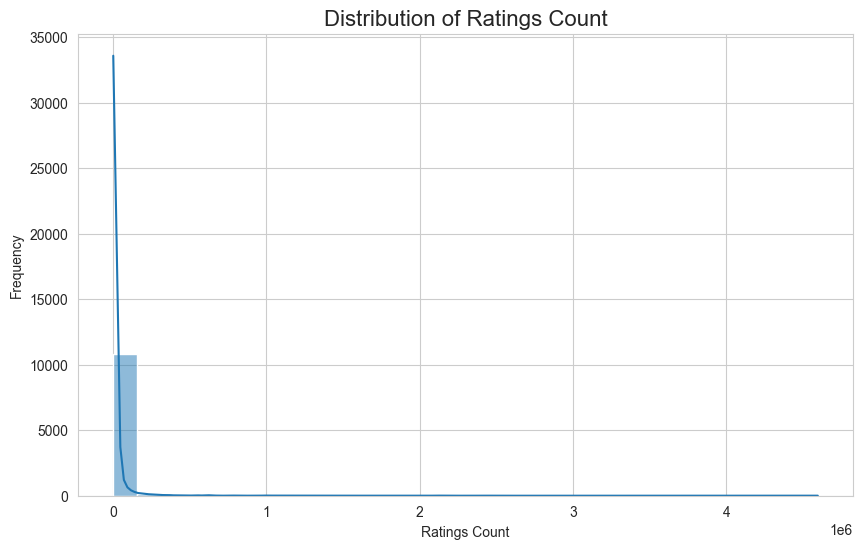

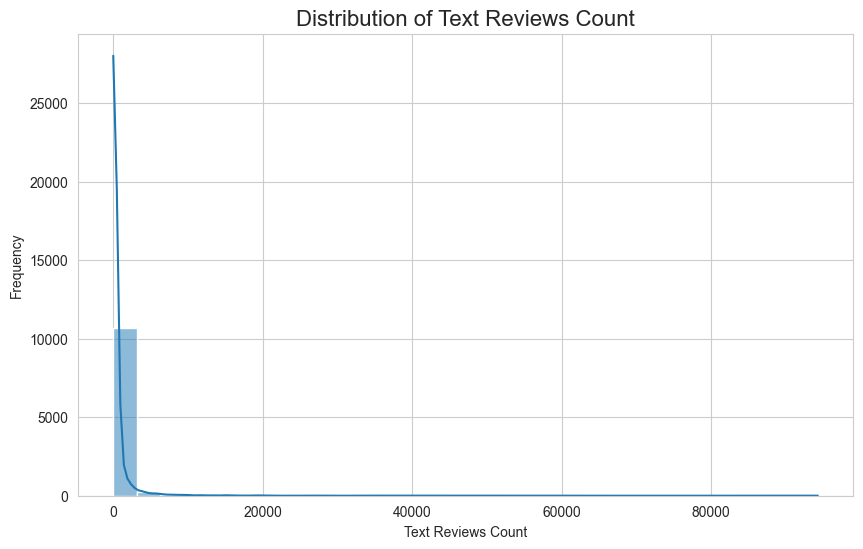

In [24]:
#Distribution plots
sns.set_style('whitegrid')

for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], bins=30, kde=True)
    
    plt.title(f'Distribution of {feature.replace("_", " ").title()}', size=16)
    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel('Frequency')
    
    plt.show()

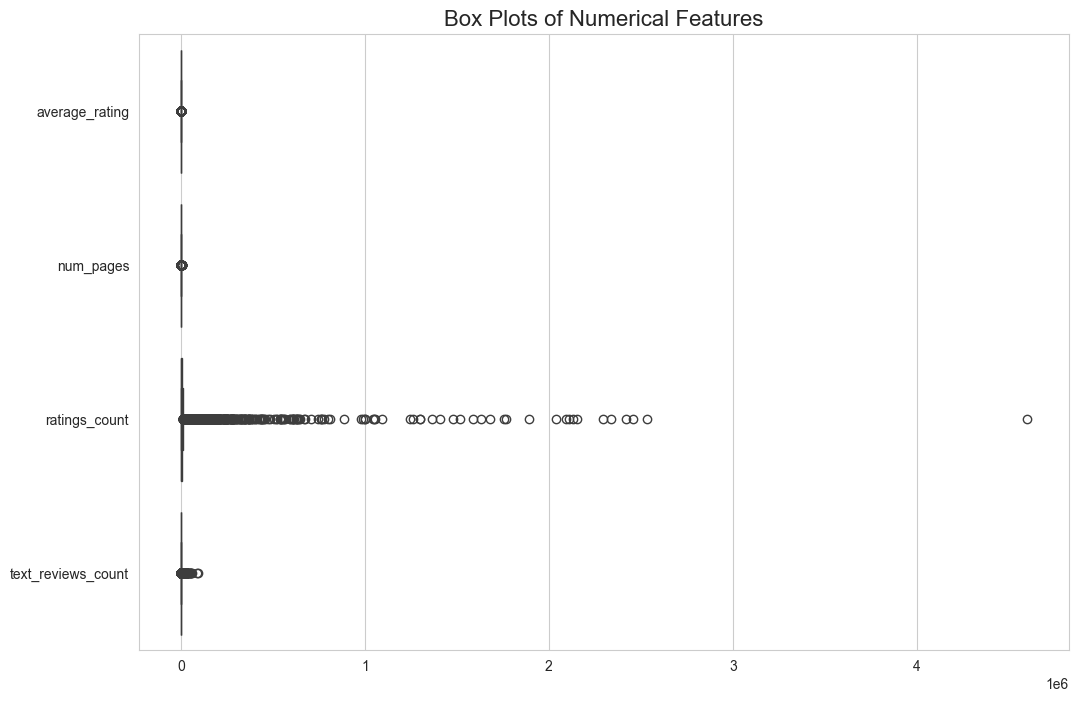

In [25]:
# Box plots for numerical features
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[numerical_features], orient='h')
plt.title('Box Plots of Numerical Features', size=16)
plt.show()

## Language

In [26]:
english_codes = ['eng', 'en-US', 'en-GB', 'en-CA']

# Replace all occurrences of these codes in the 'language_code' column with 'eng'
df['language_code'] = df['language_code'].replace(english_codes, 'eng')

C:\Users\khali\AppData\Local\Temp\ipykernel_3484\1312295405.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['language_code'], order=df['language_code'].value_counts().index, palette='viridis')


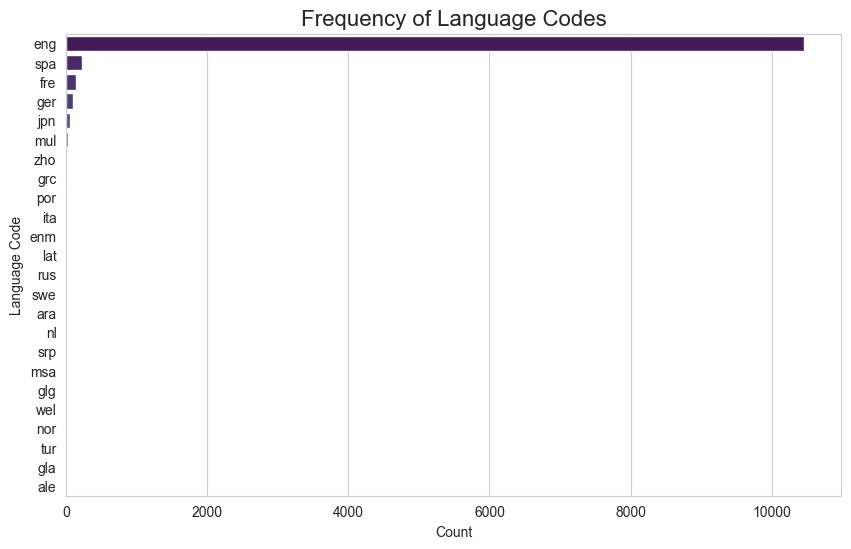

In [27]:
#Language Code
plt.figure(figsize=(10, 6))
sns.countplot(y=df['language_code'], order=df['language_code'].value_counts().index, palette='viridis')
plt.title('Frequency of Language Codes', size=16)
plt.xlabel('Count')
plt.ylabel('Language Code')
plt.show()

C:\Users\khali\AppData\Local\Temp\ipykernel_3484\2883358118.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


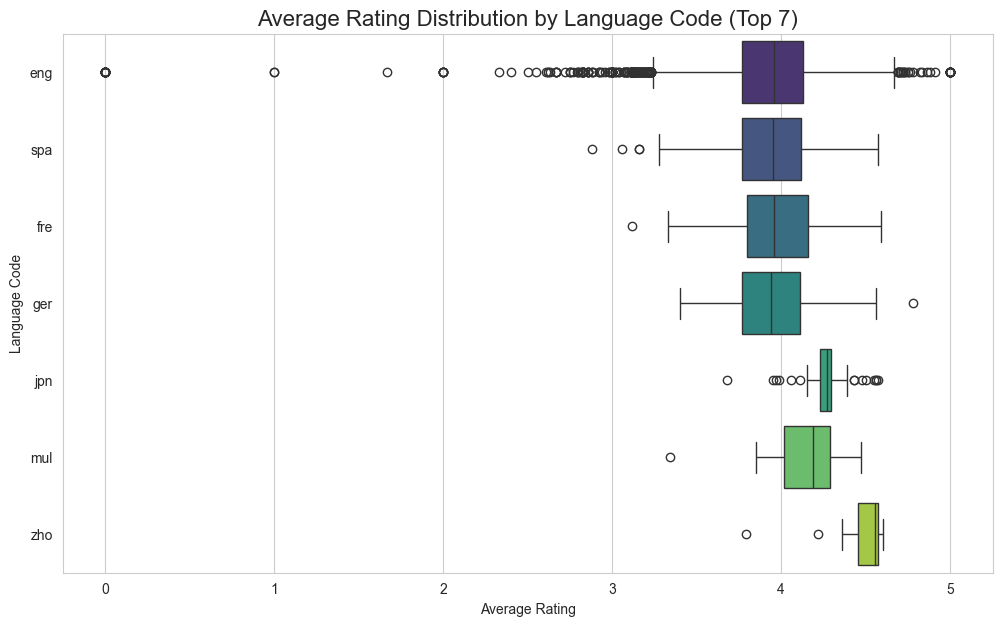

In [28]:
#Let's focus on the most common languages to keep the plot clean
top_langs = df['language_code'].value_counts().nlargest(7).index

plt.figure(figsize=(12, 7))
sns.boxplot(
    data=df[df['language_code'].isin(top_langs)],
    x='average_rating',
    y='language_code',
    order=top_langs,
    palette='viridis'
)
plt.title('Average Rating Distribution by Language Code (Top 7)', size=16)
plt.xlabel('Average Rating')
plt.ylabel('Language Code')
plt.show()

we see that english is very dominent in the dataset so we might remove it because it will create an imbalance

## Authors

In [29]:
df['authors'].unique()

array(['J.K. Rowling/Mary GrandPré', 'J.K. Rowling',
       'W. Frederick Zimmerman', ..., 'C.S. Lewis/Ana Falcão Bastos',
       'C.S. Lewis/Pauline Baynes/Ana Falcão Bastos',
       'William T. Vollmann/Larry McCaffery/Michael Hemmingson'],
      shape=(6601,), dtype=object)

we see many authors repeating

In [30]:
#we extract the main author
df['main_authors'] = df['authors'].str.split('/').str[0]

In [31]:
def clean_author(author):
    
    author = re.sub(r'[^\w\s]', '', author)
    
    # Convert the entire author to lowercase
    author = author.lower()
    
    author = re.sub(r'\s+', ' ', author)
    
    # Remove any leading or trailing whitespace
    return author.strip()


In [32]:
# Apply this function to the 'title' column to create a new 'cleaned_title' column
df['clean_main_authors'] = df['main_authors'].apply(clean_author)

In [33]:
# Display the original and cleaned titles to see the difference
print("\nOriginal vs. Cleaned Authors")
print(df[['main_authors', 'clean_main_authors']].tail(10).to_string())


Original vs. Cleaned Authors
              main_authors  clean_main_authors
11113           C.S. Lewis            cs lewis
11114           C.S. Lewis            cs lewis
11115           C.S. Lewis            cs lewis
11116           C.S. Lewis            cs lewis
11117  William T. Vollmann  william t vollmann
11118  William T. Vollmann  william t vollmann
11119  William T. Vollmann  william t vollmann
11120  William T. Vollmann  william t vollmann
11121  William T. Vollmann  william t vollmann
11122           Mark Twain          mark twain


In [34]:
df['main_authors'].unique()

array(['J.K. Rowling', 'W. Frederick Zimmerman', 'Douglas Adams', ...,
       'Dave Crane', 'Rosa Montero', 'Mario Vargas Llosa'],
      shape=(4207,), dtype=object)

C:\Users\khali\AppData\Local\Temp\ipykernel_3484\219223611.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_authors.index, x=top_authors.values, palette='plasma')


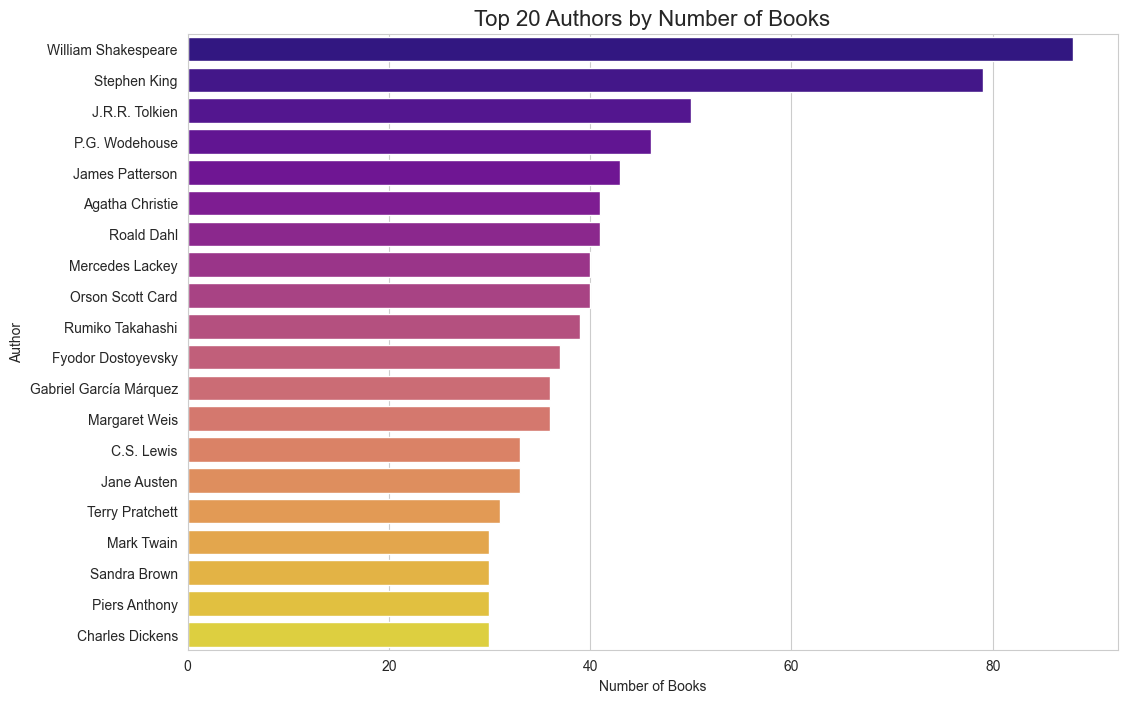

In [35]:
#Top 20 Authors
plt.figure(figsize=(12, 8))
top_authors = df['main_authors'].value_counts().nlargest(20)
sns.barplot(y=top_authors.index, x=top_authors.values, palette='plasma')
plt.title('Top 20 Authors by Number of Books', size=16)
plt.xlabel('Number of Books')
plt.ylabel('Author')
plt.show()

## Publishers

In [36]:
#We map only some prominent publishers we saw in the data (not based on anything concrete just what we saw while exploring ourselves)
publisher_map = {
    # Library of America
    "Library of America": "Library of America",

    # VIZ Media group
    "VIZ Media LLC": "VIZ Media",
    "VIZ Media": "VIZ Media",

    # Del Rey
    "Del Rey": "Del Rey",
    "Del Rey Books": "Del Rey",
    "Del Rey/Ballantine Books": "Del Rey", # As seen in the example

    # HarperCollins group
    "HarperCollins": "HarperCollins",
    "Harper Collins": "HarperCollins",
    "HarperCollins UK": "HarperCollins",
    "Harpercollins": "HarperCollins",
    "Harper Perennial": "HarperCollins",
    "HarperPerennial": "HarperCollins",
    "Ecco/Harper Perennial": "HarperCollins",

    # Puffin Books group
    "Puffin Books": "Puffin Books",
    "Puffin": "Puffin Books",
    "Puffin Books (UK)": "Puffin Books",
    "Puffin Books Ltd": "Puffin Books",

    # W. W. Norton & Company group
    "W. W. Norton & Company": "W. W. Norton & Company",
    "W.W. Norton & Company": "W. W. Norton & Company",
    "W. W. Norton Company": "W. W. Norton & Company",

    # Modern Library group
    "Modern Library": "Modern Library",
    "Modern Library (NY)": "Modern Library",
    "Modern Library Classics": "Modern Library",
    "The Modern Library": "Modern Library",

    # Penguin group
    "Penguin Books": "Penguin",
    "Penguin Books Ltd": "Penguin",
    "Penguin Books Ltd.": "Penguin",
    "Penguin Books Limited": "Penguin",
    "Penguin Books Limited (UK)": "Penguin",
    "Penguin Book Limited": "Penguin",
    "Penguin Books (NY)": "Penguin",
    "Penguin Books (NYC)": "Penguin",
    "Penguin Classics": "Penguin",
    "Penguin Classic": "Penguin",
    "Penguin (Non-Classics)": "Penguin",
    "Penguin": "Penguin",
    "Penguin UK": "Penguin",

    # Dover Publications group
    "Dover Publications": "Dover Publications",
    "Dover Publications Inc.": "Dover Publications",
    "Dover Publications (NY)": "Dover Publications",
    "Dover Publications (NYC)": "Dover Publications",

    # Oxford University Press group
    "Oxford University Press USA": "Oxford University Press, USA",
    "Oxford University Press, USA": "Oxford University Press, USA",
    "Oxford University Press": "Oxford University Press, USA"
}

In [37]:
df["publisher_normalized"] = df["publisher"].map(publisher_map)

df["publisher_normalized"] = df["publisher_normalized"].fillna("Other")

C:\Users\khali\AppData\Local\Temp\ipykernel_3484\3786240131.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=top_publishers.index, x=top_publishers.values, palette='magma')


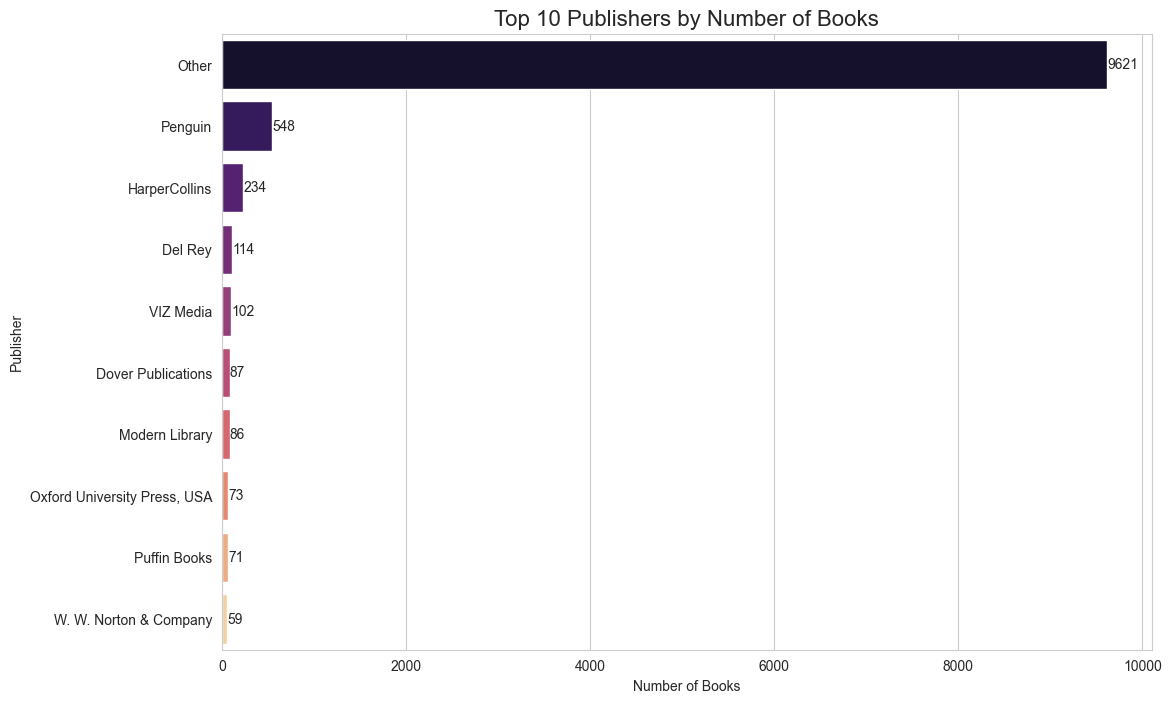

In [38]:
#Top 10 Publishers
plt.figure(figsize=(12, 8))
top_publishers = df['publisher_normalized'].value_counts().nlargest(10)
ax = sns.barplot(y=top_publishers.index, x=top_publishers.values, palette='magma')
plt.title('Top 10 Publishers by Number of Books', size=16)
plt.xlabel('Number of Books')
plt.ylabel('Publisher')

# Add the actual values to each bar
for index, value in enumerate(top_publishers.values):
    ax.text(value, index, f'{value}', va='center')

plt.show()

## Correlation matrix

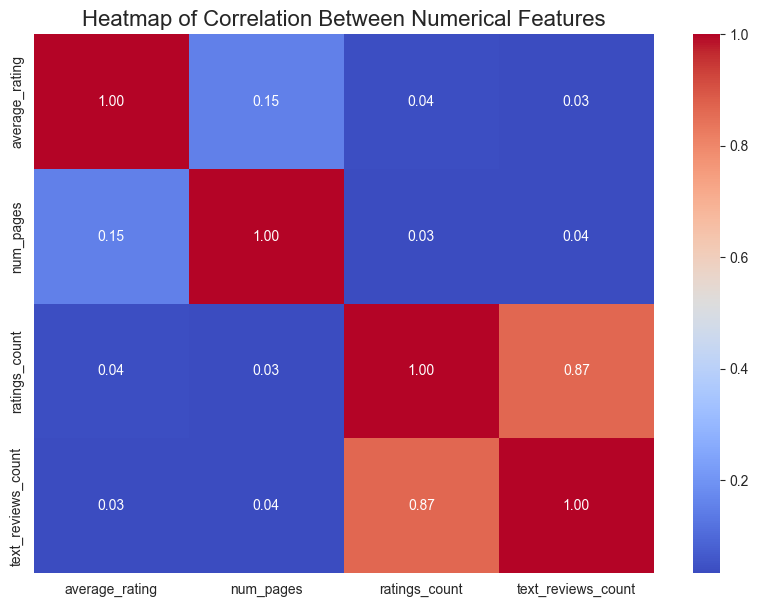

In [39]:
correlation_matrix = df[numerical_features].corr()

#Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    correlation_matrix,
    annot=True,          
    cmap='coolwarm',     
    fmt=".2f"           
)
plt.title('Heatmap of Correlation Between Numerical Features', size=16)
plt.show()

## Outliers

In [40]:
for col in numerical_features:
    #Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    
    #Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    #Define the outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    #Identify outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    print(f"\nOutliers for '{col}'")
    print(f"Column Stats: Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}")
    print(f"Outlier boundaries: < {lower_bound:.2f} or > {upper_bound:.2f}")
    print(f"Number of outliers found: {len(outliers)}")
    
    if not outliers.empty:
        #Display a sample of the outliers with only the relevant columns
        print("Sample of identified outliers (bookID, title, and value):")
        print(outliers[['bookID', 'title', col]].head())


Outliers for 'average_rating'
Column Stats: Q1=3.77, Q3=4.13, IQR=0.36
Outlier boundaries: < 3.23 or > 4.67
Number of outliers found: 249
Sample of identified outliers (bookID, title, and value):
     bookID                                              title  average_rating
4         8  Harry Potter Boxed Set  Books 1-5 (Harry Potte...            4.78
6        10       Harry Potter Collection (Harry Potter  #1-6)            4.73
96      159                          Dinner with Anna Karenina            2.99
170     406                                         Cosmopolis            3.22
198     454                         Travels in the Scriptorium            3.23

Outliers for 'num_pages'
Column Stats: Q1=196.00, Q3=416.00, IQR=220.00
Outlier boundaries: < -134.00 or > 746.00
Number of outliers found: 565
Sample of identified outliers (bookID, title, and value):
   bookID                                              title  num_pages
1       2  Harry Potter and the Order of the Phoenix (

Generated and saved box plot for 'average_rating' as 'average_rating_boxplot.png'
Generated and saved box plot for 'ratings_count' as 'ratings_count_boxplot.png'
Generated and saved box plot for 'text_reviews_count' as 'text_reviews_count_boxplot.png'


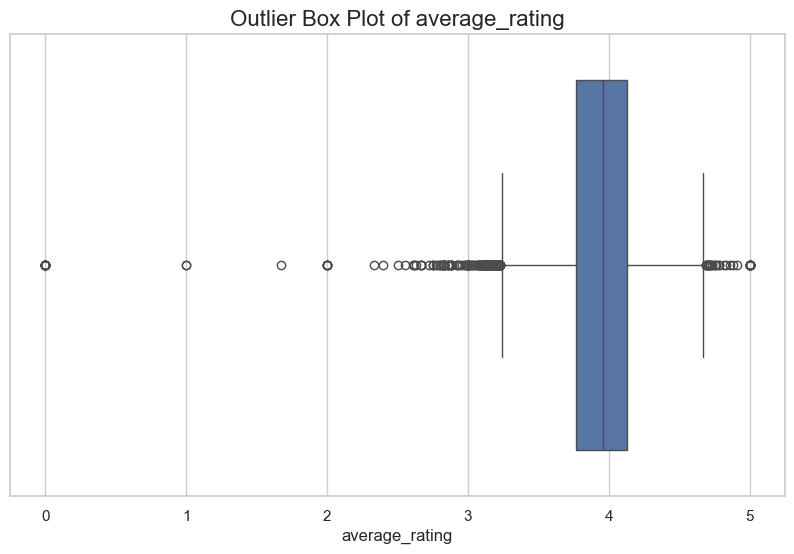

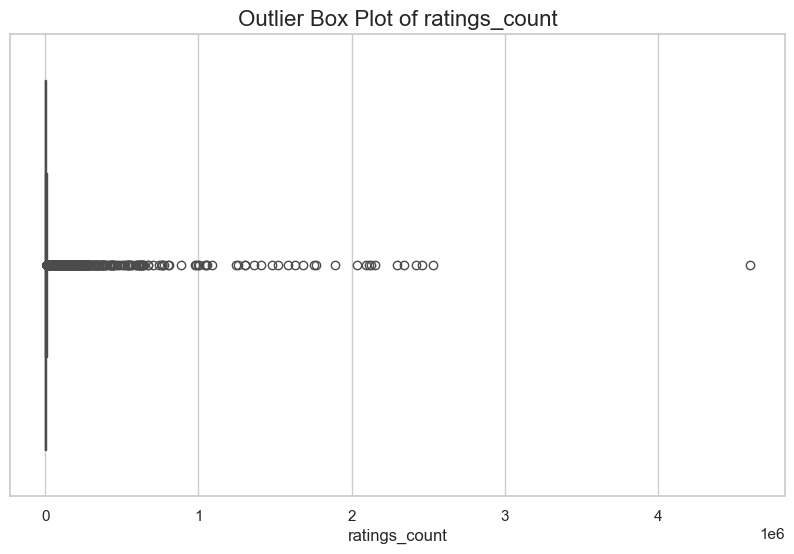

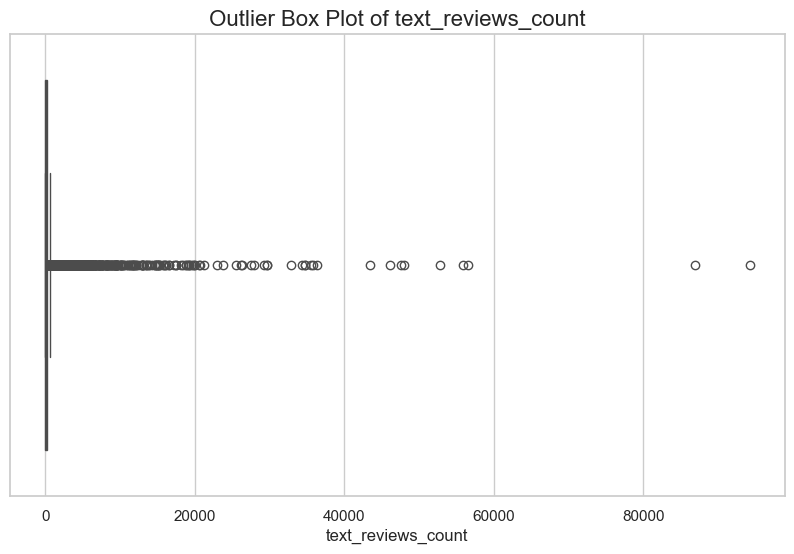

In [41]:
numerical_features = ['average_rating', 'ratings_count', 'text_reviews_count']


# Set the style for the plots
sns.set(style="whitegrid")

# Iterate through each numerical column to create a box plot
for col in numerical_features:
    plt.figure(figsize=(10, 6)) # Create a new figure for each plot
    
    # Create the box plot using seaborn
    sns.boxplot(x=df[col])
    
    # Add a title and labels for clarity
    plt.title(f'Outlier Box Plot of {col}', fontsize=16)
    plt.xlabel(col, fontsize=12)
    print(f"Generated and saved box plot for '{col}' as '{col}_boxplot.png'")


we see that there are many outliers, however they are not errors:Harry Potter series is genuinely popular and highly rated for example so we will keep them because they may represent the patterns the models will want to learn

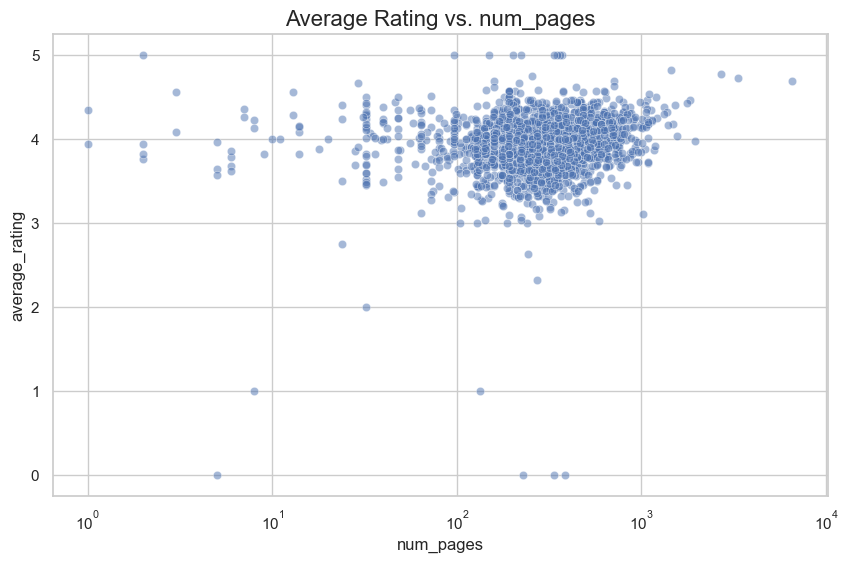

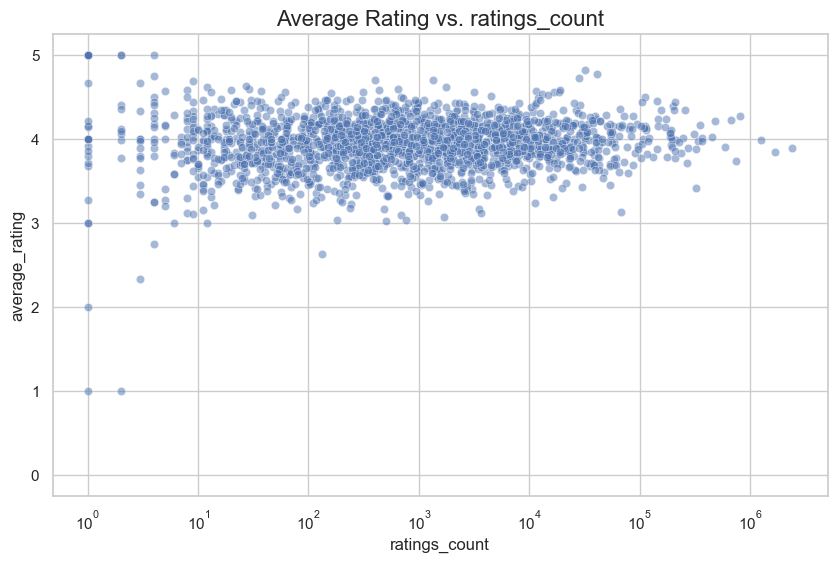

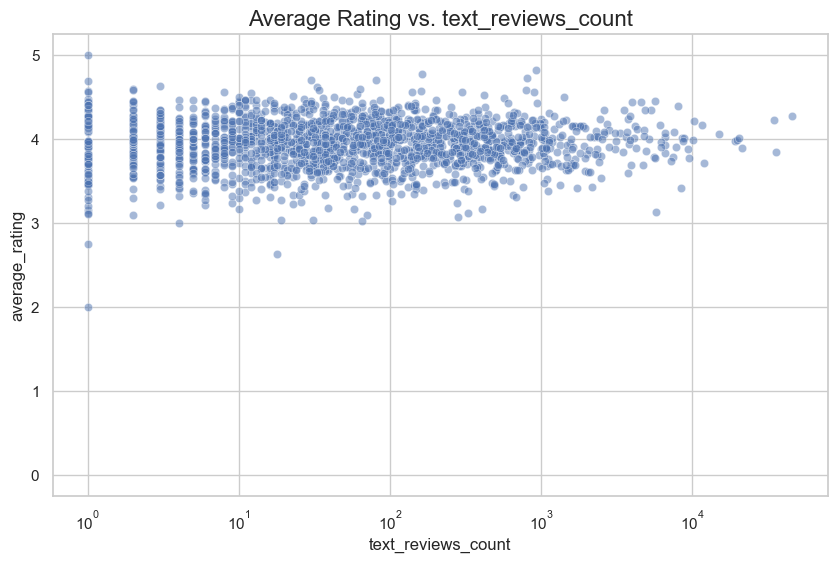

In [42]:
numerical_to_plot = ['num_pages', 'ratings_count', 'text_reviews_count']

for col in numerical_to_plot:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df.sample(n=2000, random_state=1), x=col, y='average_rating', alpha=0.5)
    plt.title(f'Average Rating vs. {col}', size=16)
    plt.xscale('log')
    plt.show()

# Data Preprocessing & Feature Engineering

In [43]:
# we drop bookID,isbn,isbn13 because they are identifiers, and we drop date columns because their insights are too noisy for a model
df.drop(columns=['bookID','isbn','isbn13'],inplace=True)

## Series and collections

In [44]:
def longest_common_prefix(strs):
    """
    Finds the longest common prefix string amongst a list of strings.
    """
    if not strs:
        return ""
    
    shortest_str = min(strs, key=len)
    for i, char in enumerate(shortest_str):
        for other in strs:
            if i >= len(other) or other[i] != char:
                return shortest_str[:i]
    return shortest_str

def create_series(df):
    """
    Generates mutually exclusive 'is_series' and 'is_collection' columns.
    """
    df = df.copy()
    
    collection_pattern = re.compile(
        r'Boxed Set|Box Set|Collection|Complete Series|Books\s\d+-\d+|#\d+-\d+', 
        re.IGNORECASE
    )
    df['is_collection'] = df['title'].str.contains(collection_pattern, na=False).astype(int)
    df['author_primary'] = df['authors'].str.split('/').str[0].str.strip()
    
    # Identify series by number in title
    number_pattern = re.compile(r'\(?#\s*(\d+)\)?|Book\s+(\d+)|Volume\s+(\d+)|Part\s+(\d+)', re.IGNORECASE)
    book_numbers = df['title'].str.extract(number_pattern)
    is_series_regex = book_numbers.notna().any(axis=1)
    author_titles = df.groupby('author_primary')['title'].apply(list)
    authors_with_multiple_books = author_titles[author_titles.apply(len) > 1].index
    series_prefixes = {}
    for author in authors_with_multiple_books:
        titles = author_titles[author]
        prefix = longest_common_prefix(titles)
        if len(prefix) > 5:
            series_prefixes[author] = prefix.strip()
    df['series_name'] = df['author_primary'].map(series_prefixes)
    is_series_prefix = df['series_name'].notna()
    provisional_is_series = (is_series_regex | is_series_prefix).astype(int)
    df['is_series'] = np.where(df['is_collection'] == 1, 0, provisional_is_series)
    df.drop(columns=['author_primary', 'series_name'], inplace=True)
    df.drop(columns=['series_book_count', 'book_number_in_series'], errors='ignore', inplace=True)

    return df


In [45]:
df = create_series(df)

## Book age

In [46]:
df['publication_year'] = pd.to_datetime(df['publication_date']).dt.year
latest_year = 2025
df['book_age'] = latest_year - df['publication_year']

## Authors

In [47]:
author_avg_rating = df.groupby("clean_main_authors")["average_rating"].mean()
df["author_avg_rating"] = df["clean_main_authors"].map(author_avg_rating)

In [48]:
joblib.dump(author_avg_rating, f'{MODELS_FOLDER}author_avg_rating.joblib')
print(f"Author average rating saved to '{MODELS_FOLDER}author_avg_rating.joblib'")

Author average rating saved to './Models/author_avg_rating.joblib'


## Ratings count & text reviews count

In [49]:
df["credibility"] = np.log10(df["ratings_count"] + 1) + np.log10(df["text_reviews_count"] + 1)

## Publisher

In [50]:
publisher_book_counts = df.groupby("publisher_normalized").size()
min_books_threshold = 50
qualified_publishers = publisher_book_counts[publisher_book_counts >= min_books_threshold].index
publisher_avg_rating = df[df["publisher_normalized"].isin(qualified_publishers)].groupby("publisher_normalized")["average_rating"].mean()
global_avg_rating = df['average_rating'].mean()
df["publisher_avg_rating"] = df["publisher_normalized"].map(publisher_avg_rating).fillna(global_avg_rating)

In [51]:
df_qualified = df[df['publisher_normalized'].isin(qualified_publishers)]
publisher_stats = df_qualified.groupby("publisher_normalized").agg(
    average_rating=('average_rating', 'mean'),
    book_count=('publisher_normalized', 'count')
).sort_values(by='average_rating', ascending=False)

top_10_publishers = publisher_stats.head(10)
print(top_10_publishers)

                        average_rating  book_count
publisher_normalized                              
VIZ Media                     4.268137         102
Library of America            4.263462          52
Del Rey                       4.002982         114
Puffin Books                  3.994930          71
Modern Library                3.975930          86
HarperCollins                 3.964231         234
W. W. Norton & Company        3.963051          59
Dover Publications            3.951609          87
Penguin                       3.927190         548
Other                         3.926782        9621


In [52]:
joblib.dump(publisher_map, f'{MODELS_FOLDER}publisher_map.joblib')
print(f"Publisher maping dictionary saved to '{MODELS_FOLDER}publisher_map.joblib'")
joblib.dump(publisher_avg_rating, f'{MODELS_FOLDER}publisher_avg_rating.joblib')
print(f"Publisher average rating saved to '{MODELS_FOLDER}publisher_avg_rating.joblib'")

Publisher maping dictionary saved to './Models/publisher_map.joblib'
Publisher average rating saved to './Models/publisher_avg_rating.joblib'


we won't drop these rows as they are truly 0 and not extremes

# Final df for modeling

In [53]:
df.columns

Index(['title', 'authors', 'average_rating', 'language_code', 'num_pages',
       'ratings_count', 'text_reviews_count', 'publication_date', 'publisher',
       'parsed_date', 'publication_year', 'main_authors', 'clean_main_authors',
       'publisher_normalized', 'is_collection', 'is_series', 'book_age',
       'author_avg_rating', 'credibility', 'publisher_avg_rating'],
      dtype='object')

In [54]:
features_to_keep = [
    'average_rating',
    'num_pages',       
    'credibility',
    'author_avg_rating', 
    'publisher_avg_rating',  
    'book_age',
    'is_series',
    'is_collection'
]

In [55]:
df_model = df[features_to_keep]

In [56]:
feature_columns = df_model.drop('average_rating', axis=1).columns.tolist()
joblib.dump(feature_columns, f"{MODELS_FOLDER}column_list.joblib")

['./Models/column_list.joblib']

In [57]:
df_model.shape

(11047, 8)

In [58]:
df_model.head()

,average_rating,num_pages,credibility,author_avg_rating,publisher_avg_rating,book_age,is_series,is_collection
0,4.57,652,10.762110,4.52125,3.926782,19,1,0
1,4.49,870,10.798788,4.52125,3.926782,21,1,0
2,4.42,352,6.190844,4.52125,3.926782,22,1,0
3,4.56,435,10.929357,4.52125,3.926782,21,1,0
4,4.78,2690,6.834788,4.52125,3.926782,21,0,1


## Correlation matrix after feature engineering

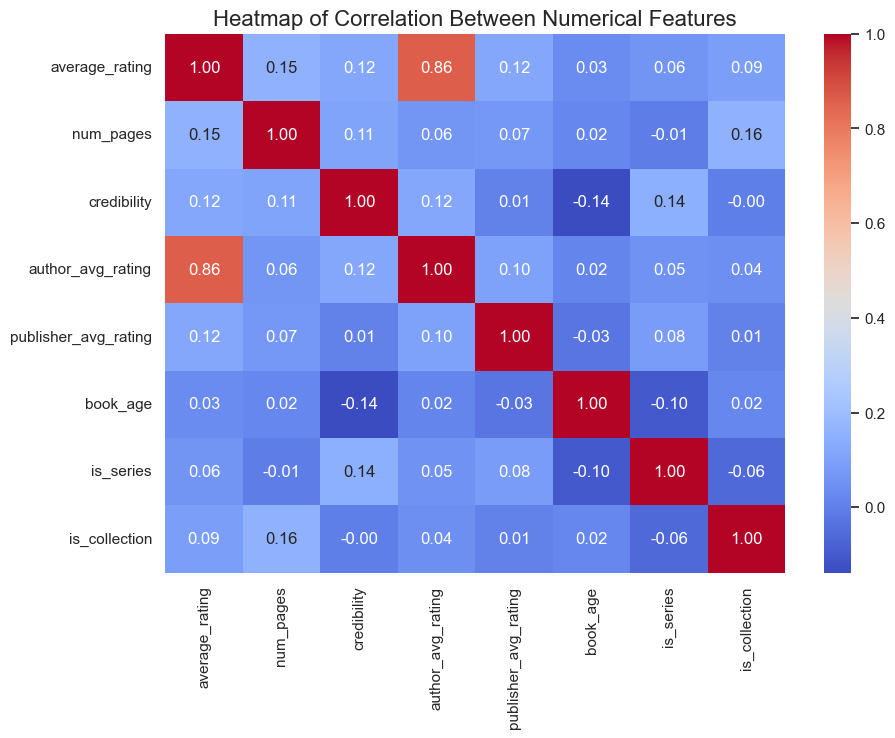

In [59]:
correlation_matrix = df_model[features_to_keep].corr()

#Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    correlation_matrix,
    annot=True,          
    cmap='coolwarm',     
    fmt=".2f"           
)
plt.title('Heatmap of Correlation Between Numerical Features', size=16)
plt.show()

# Modeling 

In [60]:
X = df_model.drop('average_rating', axis=1)
y = df_model['average_rating']

In [61]:
numerical_features_to_scale = [
    'num_pages',
    'credibility',
    'author_avg_rating', 
    'publisher_avg_rating', 
    'book_age'
]

In [62]:
# Initialize the scaler (seeing that we have outliers in our data and that they should matter instead of being removed)
scaler = QuantileTransformer(output_distribution='normal', random_state=42)
X[numerical_features_to_scale] = scaler.fit_transform(X[numerical_features_to_scale])

In [63]:
joblib.dump(scaler, f"{MODELS_FOLDER}scaler.joblib")
print(f"Scaler saved to {MODELS_FOLDER}scaler.joblib")

Scaler saved to ./Models/scaler.joblib


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=42)

In [65]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8837, 7)
(8837,)
(2210, 7)
(2210,)


## Dummy Regressor

In [66]:
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dummy = dummy_regressor.predict(X_test)

# Evaluate the DummyRegressor's performance
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
rmse_dummy = root_mean_squared_error(y_test, y_pred_dummy)
r2_dummy = r2_score(y_test, y_pred_dummy)

# Print the results
print("\nDummy Regressor (Mean Strategy) results")
print(f"Mean Absolute Error (MAE): {mae_dummy:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_dummy:.4f}")
print(f"R-squared (R²): {r2_dummy:.4f}")


Dummy Regressor (Mean Strategy) results
Mean Absolute Error (MAE): 0.2347
Root Mean Squared Error (RMSE): 0.3666
R-squared (R²): -0.0000


## Linear regression

In [67]:
#we train a simple linear regression model as a baseline
baseline_lr_model = LinearRegression()
baseline_lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [68]:
y_pred_lr = baseline_lr_model.predict(X_test)

In [69]:
#We evaluate the model
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("\nLinear Regression results")
print(f"Mean Absolute Error (MAE): {mae_lr:.4f}")
print(f"Root Mean Squared Error (MSE): {rmse_lr:.4f}")
print(f"R-squared (R²): {r2_lr:.4f}")


Linear Regression results
Mean Absolute Error (MAE): 0.1255
Root Mean Squared Error (MSE): 0.2230
R-squared (R²): 0.6301


## Advanced models

In [70]:
#we move to more advanced models but with basic hyperparameters
models = {
    "Ridge": Ridge(),
    "K-Neighbors": KNeighborsRegressor(),
    "SVR": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42),
    "LightGBM": lgb.LGBMRegressor(random_state=42)
}

In [71]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']

full_kfold_results = {}
for name, model in models.items():
    print(f"Cross-validating {name}")
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring_metrics, n_jobs=-1)
    full_kfold_results[name] = {
        "MAE": -np.mean(cv_results['test_neg_mean_absolute_error']),
        "RMSE": -np.mean(cv_results['test_neg_root_mean_squared_error']),
        "R-squared": np.mean(cv_results['test_r2'])
    }


Cross-validating Ridge
Cross-validating K-Neighbors
Cross-validating SVR
Cross-validating Random Forest
Cross-validating Gradient Boosting
Cross-validating XGBoost
Cross-validating LightGBM


In [72]:
results_df = pd.DataFrame(full_kfold_results).T
results_df = results_df.sort_values(by="R-squared", ascending=False)
print("\nFull K-Fold Cross-Validation Results")
print(results_df)


Full K-Fold Cross-Validation Results
                        MAE      RMSE  R-squared
Gradient Boosting  0.108839  0.177967   0.728555
SVR                0.113914  0.180348   0.724271
LightGBM           0.112042  0.179890   0.722762
Random Forest      0.111322  0.180371   0.720145
XGBoost            0.117645  0.189502   0.694512
K-Neighbors        0.126168  0.189497   0.693744
Ridge              0.122585  0.207755   0.638172


to create a gridsearch we see the default parameters first

In [73]:
lgbm_default = lgb.LGBMRegressor(random_state=42)
print(lgbm_default.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [74]:
gb_default = GradientBoostingRegressor(random_state=42)
print(gb_default.get_params())

{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [75]:
rf_default = RandomForestRegressor(random_state=42)
print(rf_default.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [76]:
xgb_default = xgb.XGBRegressor(random_state=42)
print(xgb_default.get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [77]:
#moving to more advanced tuning using RandomizedSearchCV on the top 4 best models (based on R²)

#LightGBM
lgbm_grid = {
    "n_estimators": [200, 400, 600, 800],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "num_leaves": [20, 31, 40, 50],
    "max_depth": [5, 10, 20],
}

#GradientBoosting
gb_grid = {
    "n_estimators": [200, 400, 600, 800],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "max_depth": [5, 10, 20],
    "subsample": [0.7, 0.9, 1.0],
    "max_features": ['sqrt', 'log2']
}

#XGBoost
xgb_grid = {
    "n_estimators": [200, 400, 600, 800],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "max_depth": [5, 10, 20],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0]
    
}

#2. Random Forest
rf_grid = {
    "n_estimators": [200, 400, 600, 800],
    "max_features": [0.8, 0.9, 1.0],
    "max_depth": [5, 10, 20],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10]
}


models_to_tune = {
    
    "LightGBM": (lgb.LGBMRegressor(random_state=42), lgbm_grid),
    "XGBoost": (xgb.XGBRegressor(random_state=42), xgb_grid),
    "GradientBoosting": (GradientBoostingRegressor(random_state=42), gb_grid),
    "Random Forest": (RandomForestRegressor(random_state=42), rf_grid),
}

In [78]:
tuned_results = {}
best_params_all_models = {}
best_overall_model = None
best_overall_model_name = ""
best_overall_score = -np.inf

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for name, (model, params) in models_to_tune.items():
    print(f"\nTuning {name}")
    
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=30,
        cv=kfold,
        verbose=1,
        random_state=42,
        n_jobs=-1,
        scoring='r2'
    )
    
    random_search.fit(X_train, y_train)
    
    best_params_all_models[name] = random_search.best_params_
    print(f"Best params for {name}: {random_search.best_params_}")
    
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    r_squared = r2_score(y_test, y_pred)
    
    tuned_results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": root_mean_squared_error(y_test, y_pred),
        "R-squared": r_squared
    }
    
    if r_squared > best_overall_score:
        best_overall_score = r_squared
        best_overall_model = best_model
        best_overall_model_name = name




Tuning LightGBM
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 8837, number of used features: 7
[LightGBM] [Info] Start training from score 3.934340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [79]:
print(f"The best overall model is: {best_overall_model_name}")
print(f"Best R-squared score: {best_overall_score:.6f}")
print(f"Parameters for the best model: {best_params_all_models[best_overall_model_name]}")

The best overall model is: Random Forest
Best R-squared score: 0.803781
Parameters for the best model: {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.8, 'max_depth': 10}


In [80]:
print("Performance of Tuned Models")
tuned_results_df = pd.DataFrame(tuned_results).T.sort_values(by="R-squared", ascending=False)
print(tuned_results_df)

Performance of Tuned Models
                       MAE      RMSE  R-squared
Random Forest     0.104469  0.162396   0.803781
LightGBM          0.107875  0.168347   0.789134
GradientBoosting  0.107557  0.170062   0.784817
XGBoost           0.108993  0.170663   0.783295


In [81]:
model_filename = f'{MODELS_FOLDER}best_model.joblib'
joblib.dump(best_overall_model, model_filename)
print(f"\nBest overall model ('{best_overall_model_name}') saved successfully to '{model_filename}'")


Best overall model ('Random Forest') saved successfully to './Models/best_model.joblib'


# Evaluation

In [82]:
baseline_results = {
    'Linear Regression': {
        'MAE': mae_lr,
        'RMSE': rmse_lr,
        'R-squared': r2_lr
    },
    'Dummy Regressor': {
        'MAE': mae_dummy,
        'RMSE': rmse_dummy,
        'R-squared': r2_dummy
    }
}

# Create a DataFrame from the baseline results dictionary
baseline_results_df = pd.DataFrame(baseline_results).T
results_df = results_df.round(2)
baseline_results_df = baseline_results_df.round(2)
# Combine the tuned results and baseline results DataFrames
final_results_df = pd.concat([tuned_results_df, baseline_results_df])

# Sort the final DataFrame by R-squared in descending order
final_results_df = final_results_df.sort_values(by="R-squared", ascending=False)

# Display the final combined results
print(final_results_df)

                        MAE      RMSE  R-squared
Random Forest      0.104469  0.162396   0.803781
LightGBM           0.107875  0.168347   0.789134
GradientBoosting   0.107557  0.170062   0.784817
XGBoost            0.108993  0.170663   0.783295
Linear Regression  0.130000  0.220000   0.630000
Dummy Regressor    0.230000  0.370000  -0.000000


# Explainability

## Feature importance

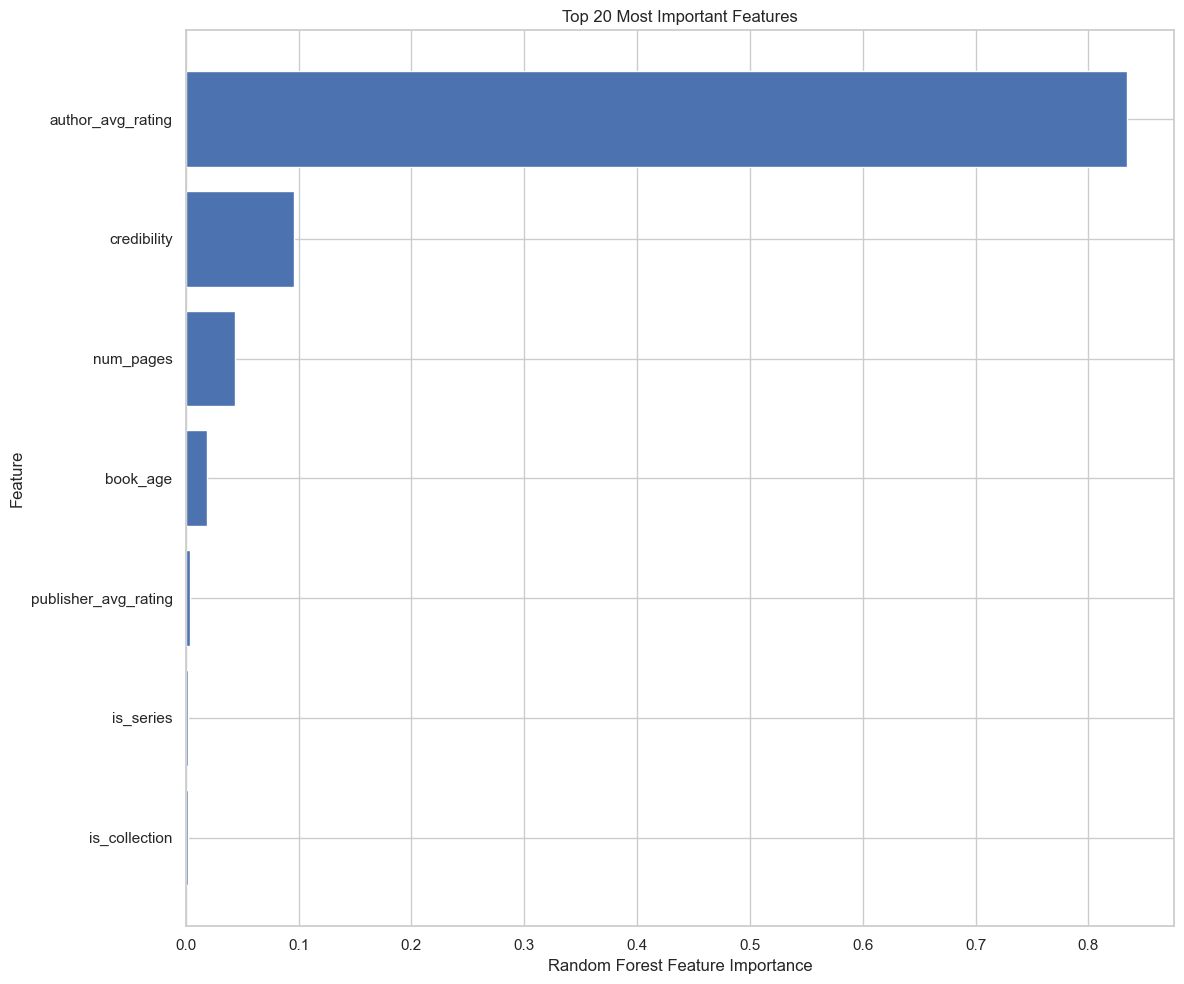

In [83]:
MODEL_FILENAME = model_filename
best_model = joblib.load(MODEL_FILENAME)

feature_names = [
    'num_pages', 
    'credibility',
    'author_avg_rating', 
    'publisher_avg_rating', 
    'book_age',
    'is_series',
    'is_collection'
]

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(12, 10))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel(f"{best_overall_model_name} Feature Importance")
plt.ylabel("Feature")
plt.title("Top 20 Most Important Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Shap

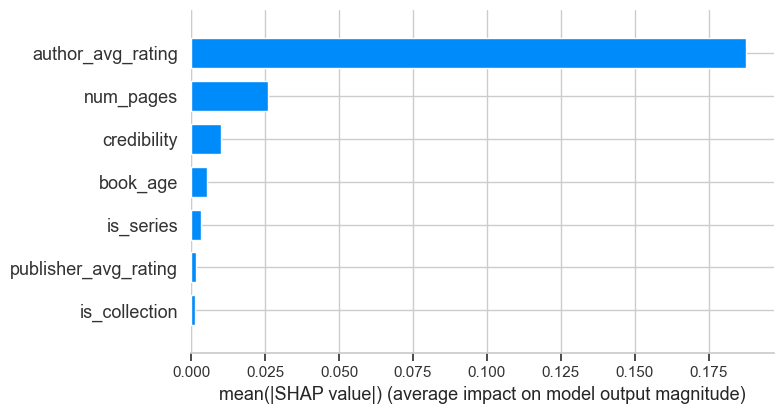

In [84]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar",feature_names=feature_names)

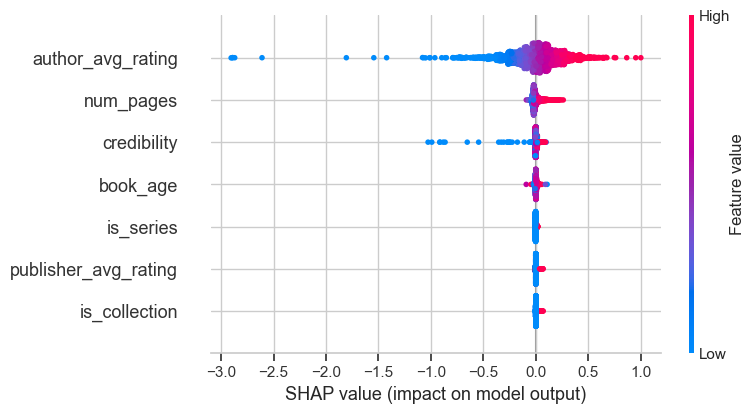

In [85]:
shap.summary_plot(shap_values, X_test,feature_names=feature_names)

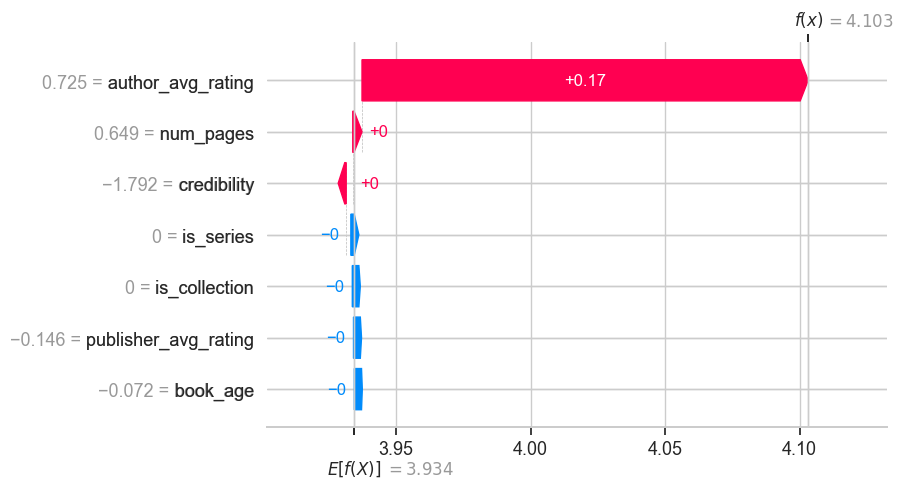

In [86]:
i = 3  
explainer = shap.TreeExplainer(best_model)
sv = explainer(X_test)                      

row = X_test.iloc[i]     
base = float(np.ravel(explainer.expected_value)[0])

shap.waterfall_plot(shap.Explanation(
    values=sv.values[i],
    base_values=base,
    data=row,
    feature_names=feature_names  
))